In [229]:
import torch
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import os
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image


import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm


if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available, using CPU.")


Using GPU: NVIDIA GeForce RTX 4070


In [230]:

training_data = datasets.Flowers102(
    root="data",
    split="train",
    download=True,
    transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(), transforms.RandomHorizontalFlip(),
                                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                    transforms.RandomVerticalFlip(), transforms.RandomRotation(45)]),
)

# Download test data from open datasets.
test_data = datasets.Flowers102(
    root="data",
    split="test",
    download=True,
    transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(),
                                   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]),
)

# Download test data from open datasets.
val_data = datasets.Flowers102(
    root="data",
    split="val",
    download=True,
    transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(),
                                   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]),
)




In [251]:
batch_size = 32
num_classes = 102
learning_rate = 0.001
num_epochs = 100

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

In [252]:
# Activation after batch 

In [253]:
# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.batch_layer1 = nn.BatchNorm2d(num_features=128) 
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
        self.batch_layer2 = nn.BatchNorm2d(num_features=512)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_layer5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
        self.conv_layer6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
        self.batch_layer3 = nn.BatchNorm2d(num_features=512)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(8192 , 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.batch_layer1(out)
        out = self.relu1(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.batch_layer2(out)
        out = self.relu1(out)
        out = self.max_pool2(out)

        out = self.conv_layer5(out)
        out = self.conv_layer6(out)
        out = self.batch_layer3(out)
        out = self.relu1(out)
        out = self.max_pool3(out)
                
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [254]:

# Define the neural network
net = Net(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

In [255]:
# Function to save the network's state
def save_network(network, epoch_label):
    save_filename = 'net_%s.pth' % epoch_label
    save_path = os.path.join(save_filename)
    torch.save(network.state_dict(), save_path)
    
# Function to test validation data and get accuracy
def test_validation_data(network):
    network.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = network(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        return (100 * correct / total)

# Lists to store loss values and validation accuracies
loss_values = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_dataloader):  
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        net = net.to(device)  # Move the model to the same device as input tensors
        outputs = net(images)
        loss = criterion(outputs, labels)
      
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    loss_values.append(epoch_loss)
    
    # Validation accuracy calculation
    if epoch % 5 == 0:
        val_accuracy = test_validation_data(net)
        val_accuracies.append(val_accuracy)
        save_network(net, epoch)
        print("Epoch [{}/{}], Loss: {:.4f}, Validation Accuracy: {:.2f}%".format(epoch+1, num_epochs, epoch_loss, val_accuracy))



Epoch [1/100], Loss: 4.5662, Validation Accuracy: 5.20%
Epoch [6/100], Loss: 3.3543, Validation Accuracy: 12.84%
Epoch [11/100], Loss: 2.6376, Validation Accuracy: 21.27%
Epoch [16/100], Loss: 2.0883, Validation Accuracy: 24.51%
Epoch [21/100], Loss: 1.6249, Validation Accuracy: 25.49%
Epoch [26/100], Loss: 1.2237, Validation Accuracy: 29.61%
Epoch [31/100], Loss: 0.8827, Validation Accuracy: 33.14%
Epoch [36/100], Loss: 0.7117, Validation Accuracy: 33.73%
Epoch [41/100], Loss: 0.5012, Validation Accuracy: 34.80%
Epoch [46/100], Loss: 0.3817, Validation Accuracy: 36.67%
Epoch [51/100], Loss: 0.2890, Validation Accuracy: 36.96%
Epoch [56/100], Loss: 0.2906, Validation Accuracy: 38.43%
Epoch [61/100], Loss: 0.2516, Validation Accuracy: 38.73%
Epoch [66/100], Loss: 0.2173, Validation Accuracy: 36.57%
Epoch [71/100], Loss: 0.0956, Validation Accuracy: 38.73%
Epoch [76/100], Loss: 0.1133, Validation Accuracy: 38.14%
Epoch [81/100], Loss: 0.1018, Validation Accuracy: 39.41%
Epoch [86/100], L

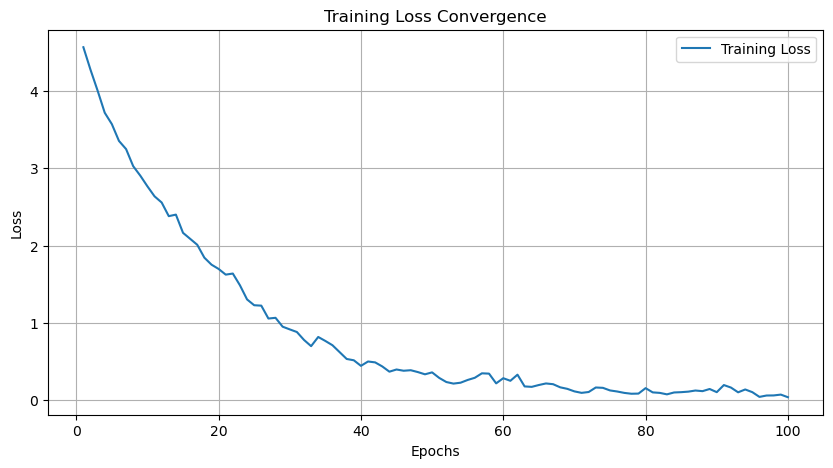

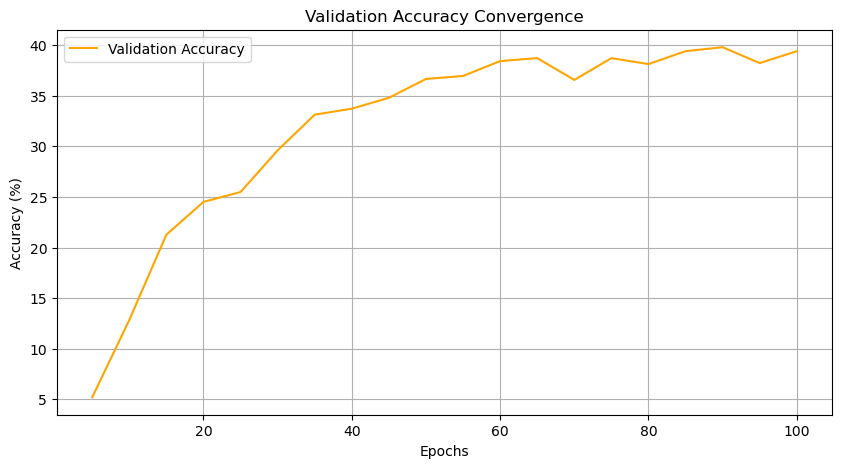

Accuracy of the network on the test images: 35.68%


In [256]:
# Plotting the convergence curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Convergence')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(5, num_epochs + 1, 5), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Convergence')
plt.grid(True)
plt.legend()
plt.show()

# Evaluate the network on test data
net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the test images: {:.2f}%'.format(100 * correct / total))

In [257]:
# Preprocess the image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Load the trained model
model = Net(num_classes)
model.eval()

# Make a single inference on an image
image_path = 'azalea.jpg'
image = preprocess_image(image_path)
with torch.no_grad():
    outputs = model(image)

# Get the predicted class
_, predicted = torch.max(outputs, 1)
predicted_class = predicted.item()
print("Predicted class:", predicted_class)

Predicted class: 15


In [ ]:
# Elu activation model

In [66]:
class Net(nn.Module):
	
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.batch_layer1 = nn.BatchNorm2d(num_features=128) 
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
        self.batch_layer2 = nn.BatchNorm2d(num_features=512)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
        self.conv_layer6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
        self.batch_layer3 = nn.BatchNorm2d(num_features=512)
        self.max_pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1 = nn.Linear(8192 , 128)
        self.elu1 = nn.ELU()
        self.fc2 = nn.Linear(128, num_classes)
    

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.batch_layer1(out)
        out = self.elu1(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.batch_layer2(out)
        out = self.elu1(out)
        out = self.max_pool2(out)

        out = self.conv_layer5(out)
        out = self.conv_layer6(out)
        out = self.batch_layer3(out)
        out = self.elu1(out)
        out = self.max_pool3(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.elu1(out)
        out = self.fc2(out)
        return out

net = Net(num_classes)

In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)



In [68]:
# Lists to store loss values and validation accuracies
loss_values = []
val_accuracies = []


# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_dataloader):  
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        net = net.to(device)  # Move the model to the same device as input tensors
        outputs = net(images)
        loss = criterion(outputs, labels)
      
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    loss_values.append(epoch_loss)
    
    # Validation accuracy calculation
    if epoch % 5 == 0:
        val_accuracy = test_validation_data(net)
        val_accuracies.append(val_accuracy)
        save_network(net, epoch)
        print("Epoch [{}/{}], Loss: {:.4f}, Validation Accuracy: {:.2f}%".format(epoch+1, num_epochs, epoch_loss, val_accuracy))


Epoch [1/100], Loss: 4.4332, Validation Accuracy: 9.31%
Epoch [6/100], Loss: 1.5482, Validation Accuracy: 20.69%
Epoch [11/100], Loss: 0.0841, Validation Accuracy: 24.71%
Epoch [16/100], Loss: 0.0081, Validation Accuracy: 25.10%
Epoch [21/100], Loss: 0.0007, Validation Accuracy: 26.08%
Epoch [26/100], Loss: 0.0004, Validation Accuracy: 26.37%
Epoch [31/100], Loss: 0.0003, Validation Accuracy: 26.37%
Epoch [36/100], Loss: 0.0003, Validation Accuracy: 26.37%
Epoch [41/100], Loss: 0.0002, Validation Accuracy: 26.47%
Epoch [46/100], Loss: 0.0002, Validation Accuracy: 26.57%
Epoch [51/100], Loss: 0.0002, Validation Accuracy: 26.57%
Epoch [56/100], Loss: 0.0001, Validation Accuracy: 26.47%
Epoch [61/100], Loss: 0.0001, Validation Accuracy: 26.27%
Epoch [66/100], Loss: 0.0001, Validation Accuracy: 26.18%
Epoch [71/100], Loss: 0.0001, Validation Accuracy: 26.18%
Epoch [76/100], Loss: 0.0001, Validation Accuracy: 26.27%
Epoch [81/100], Loss: 0.0001, Validation Accuracy: 26.27%
Epoch [86/100], L

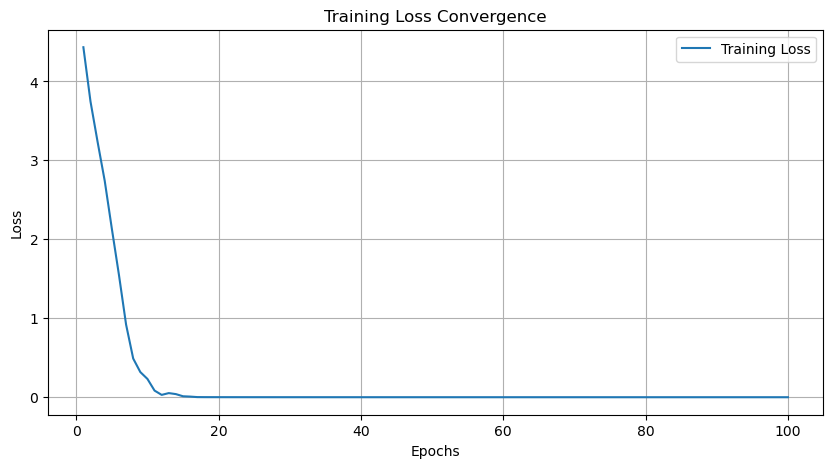

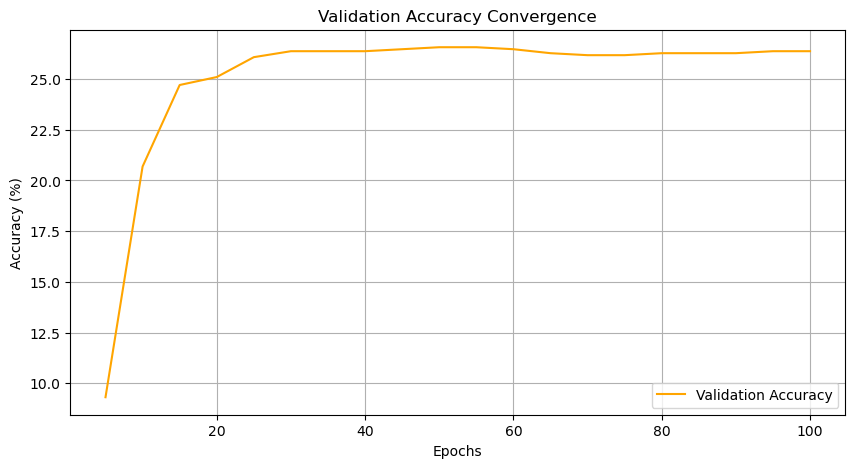

Accuracy of the network on the 6149 train images: 21.515693608716866 %


In [69]:
# Plotting the convergence curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Convergence')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(5, num_epochs + 1, 5), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Convergence')
plt.grid(True)
plt.legend()
plt.show()


net.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(total, 100 * correct / total))

In [70]:
# Load the trained model
model = Net(num_classes)
model.eval()

# Make a single inference on an image
image_path = 'azalea.jpg'
image = preprocess_image(image_path)
with torch.no_grad():
    outputs = model(image)

# Get the predicted class
_, predicted = torch.max(outputs, 1)
predicted_class = predicted.item()
print("Predicted class:", predicted_class)

Predicted class: 28


In [71]:
class Net(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.batch_layer1 = nn.BatchNorm2d(num_features=64) 
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.batch_layer2 = nn.BatchNorm2d(num_features=128)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.batch_layer3 = nn.BatchNorm2d(num_features=256)
        self.max_pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.batch_layer4 = nn.BatchNorm2d(num_features=512)
        self.max_pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1 = nn.Linear(2048 , 128)
        self.relu1 = nn.PReLU()
        self.fc2 = nn.Linear(128, num_classes)
    

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.batch_layer1(out)
        out = self.relu1(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer2(out)
        out = self.batch_layer2(out)
        out = self.relu1(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.batch_layer3(out)
        out = self.relu1(out)
        out = self.max_pool3(out)

        out = self.conv_layer4(out)
        out = self.batch_layer4(out)
        out = self.relu1(out)
        out = self.max_pool4(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

net = Net(num_classes)

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [73]:

loss_values = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_dataloader):  
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        net = net.to(device)  # Move the model to the same device as input tensors
        outputs = net(images)
        loss = criterion(outputs, labels)
      
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    loss_values.append(epoch_loss)
    
    # Validation accuracy calculation
    if epoch % 5 == 0:
        val_accuracy = test_validation_data(net)
        val_accuracies.append(val_accuracy)
        save_network(net, epoch)
        print("Epoch [{}/{}], Loss: {:.4f}, Validation Accuracy: {:.2f}%".format(epoch+1, num_epochs, epoch_loss, val_accuracy))


Epoch [1/100], Loss: 4.3981, Validation Accuracy: 5.00%
Epoch [6/100], Loss: 1.8081, Validation Accuracy: 23.43%
Epoch [11/100], Loss: 0.1670, Validation Accuracy: 29.90%
Epoch [16/100], Loss: 0.1039, Validation Accuracy: 29.41%
Epoch [21/100], Loss: 0.0914, Validation Accuracy: 29.41%
Epoch [26/100], Loss: 0.0579, Validation Accuracy: 29.61%
Epoch [31/100], Loss: 0.0057, Validation Accuracy: 31.37%
Epoch [36/100], Loss: 0.0001, Validation Accuracy: 31.57%
Epoch [41/100], Loss: 0.0001, Validation Accuracy: 32.06%
Epoch [46/100], Loss: 0.0000, Validation Accuracy: 32.16%
Epoch [51/100], Loss: 0.0000, Validation Accuracy: 32.25%
Epoch [56/100], Loss: 0.0000, Validation Accuracy: 32.45%
Epoch [61/100], Loss: 0.0000, Validation Accuracy: 32.75%
Epoch [66/100], Loss: 0.0000, Validation Accuracy: 32.35%
Epoch [71/100], Loss: 0.0000, Validation Accuracy: 32.45%
Epoch [76/100], Loss: 0.0000, Validation Accuracy: 32.45%
Epoch [81/100], Loss: 0.0000, Validation Accuracy: 32.45%
Epoch [86/100], L

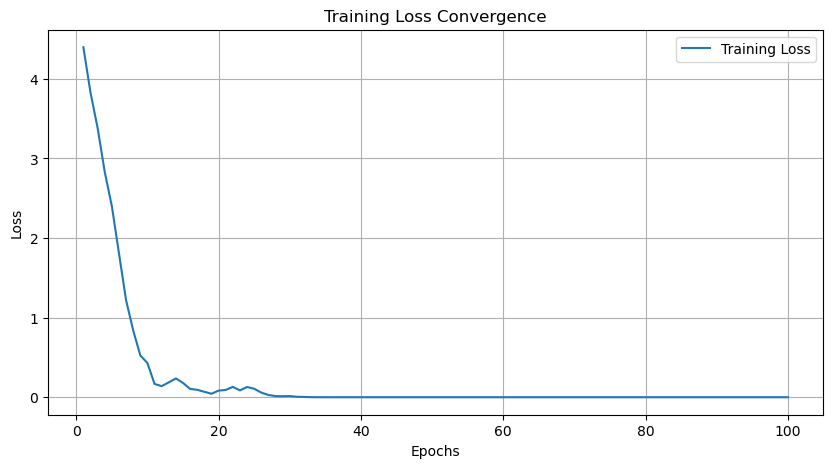

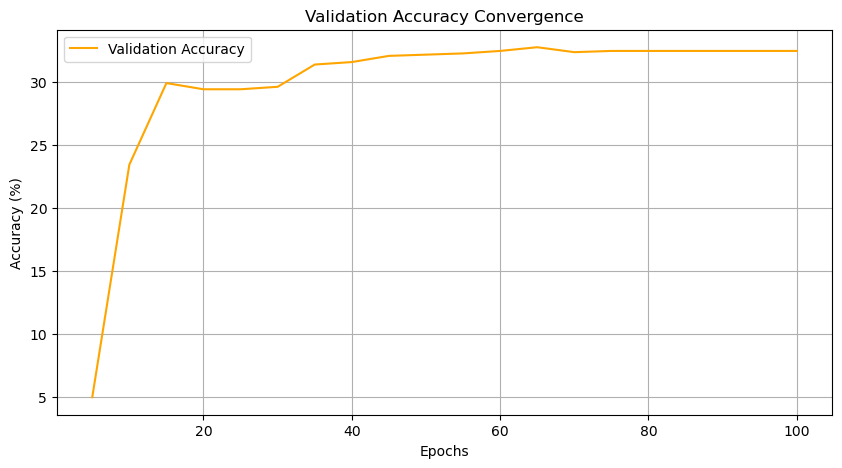

Accuracy of the network on the 6149 train images: 28.492437794763376 %


In [74]:
# Plotting the convergence curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Convergence')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(5, num_epochs + 1, 5), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Convergence')
plt.grid(True)
plt.legend()
plt.show()


net.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(total, 100 * correct / total))

Predicted class: 35


In [76]:
# Final model
class Net(nn.Module):
	
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.batch_layer1 = nn.BatchNorm2d(num_features=64) 
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.batch_layer2 = nn.BatchNorm2d(num_features=128)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.batch_layer3 = nn.BatchNorm2d(num_features=256)
        self.max_pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.batch_layer4 = nn.BatchNorm2d(num_features=512)
        self.max_pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1 = nn.Linear(2048 , 128)
        self.relu1 = nn.PReLU()
        self.fc2 = nn.Linear(128, num_classes)
    

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.batch_layer1(out)
        out = self.relu1(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer2(out)
        out = self.batch_layer2(out)
        out = self.relu1(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.batch_layer3(out)
        out = self.relu1(out)
        out = self.max_pool3(out)

        out = self.conv_layer4(out)
        out = self.batch_layer4(out)
        out = self.relu1(out)
        out = self.max_pool4(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

net = Net(num_classes)

In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

In [78]:

loss_values = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_dataloader):  
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        net = net.to(device)  # Move the model to the same device as input tensors
        outputs = net(images)
        loss = criterion(outputs, labels)
      
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    loss_values.append(epoch_loss)
    
    # Validation accuracy calculation
    if epoch % 5 == 0:
        val_accuracy = test_validation_data(net)
        val_accuracies.append(val_accuracy)
        save_network(net, epoch)
        print("Epoch [{}/{}], Loss: {:.4f}, Validation Accuracy: {:.2f}%".format(epoch+1, num_epochs, epoch_loss, val_accuracy))


Epoch [1/100], Loss: 4.5874, Validation Accuracy: 5.10%
Epoch [6/100], Loss: 2.3088, Validation Accuracy: 20.49%
Epoch [11/100], Loss: 0.2441, Validation Accuracy: 27.84%
Epoch [16/100], Loss: 0.0200, Validation Accuracy: 30.39%
Epoch [21/100], Loss: 0.0013, Validation Accuracy: 31.47%
Epoch [26/100], Loss: 0.0008, Validation Accuracy: 31.67%
Epoch [31/100], Loss: 0.0006, Validation Accuracy: 31.76%
Epoch [36/100], Loss: 0.0004, Validation Accuracy: 31.47%
Epoch [41/100], Loss: 0.0004, Validation Accuracy: 31.47%
Epoch [46/100], Loss: 0.0003, Validation Accuracy: 31.47%
Epoch [51/100], Loss: 0.0003, Validation Accuracy: 31.47%
Epoch [56/100], Loss: 0.0002, Validation Accuracy: 31.57%
Epoch [61/100], Loss: 0.0002, Validation Accuracy: 31.57%
Epoch [66/100], Loss: 0.0002, Validation Accuracy: 31.57%
Epoch [71/100], Loss: 0.0002, Validation Accuracy: 31.67%
Epoch [76/100], Loss: 0.0001, Validation Accuracy: 31.76%
Epoch [81/100], Loss: 0.0001, Validation Accuracy: 31.57%
Epoch [86/100], L

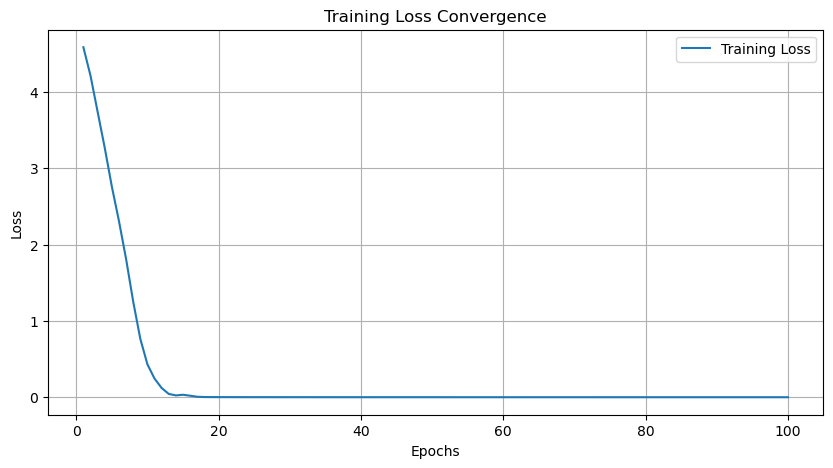

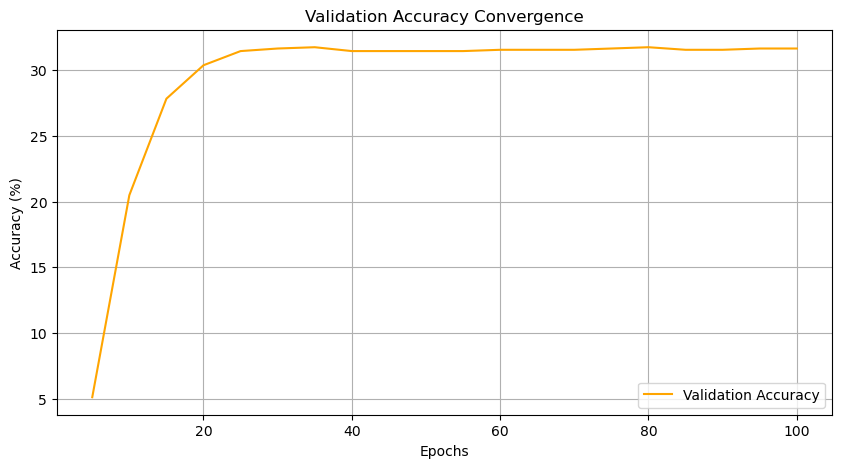

Accuracy of the network on the 6149 train images: 25.646446576679136 %


In [79]:
# Plotting the convergence curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Convergence')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(5, num_epochs + 1, 5), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Convergence')
plt.grid(True)
plt.legend()
plt.show()


net.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(total, 100 * correct / total))

In [80]:
# Load the trained model
model = Net(num_classes)
model.eval()

# Make a single inference on an image
image_path = 'azalea.jpg'
image = preprocess_image(image_path)
with torch.no_grad():
    outputs = model(image)

# Get the predicted class
_, predicted = torch.max(outputs, 1)
predicted_class = predicted.item()
print("Predicted class:", predicted_class)

Predicted class: 99


In [ ]:
#vgg

In [232]:
# Load pre-trained VGG16 model
vgg_model = models.vgg16(pretrained=True)

# Freeze the parameters so that we don't backpropagate through them
for param in vgg_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to output 102 classes
vgg_model.classifier[6] = nn.Linear(4096, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=learning_rate)
vgg_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [233]:
# Lists to store training loss and validation accuracy
loss_values = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    vgg_model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = vgg_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
    epoch_loss = running_loss / len(training_data)
    loss_values.append(epoch_loss)
    
    # Validation
    vgg_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    print("Epoch [{}/{}], Loss: {:.4f}, Validation Accuracy: {:.2f}%".format(epoch+1, num_epochs, epoch_loss, val_accuracy))


Epoch [1/100], Loss: 4.7369, Validation Accuracy: 0.14%
Epoch [2/100], Loss: 3.1609, Validation Accuracy: 0.20%
Epoch [3/100], Loss: 2.7742, Validation Accuracy: 0.24%
Epoch [4/100], Loss: 2.5747, Validation Accuracy: 0.26%
Epoch [5/100], Loss: 2.4281, Validation Accuracy: 0.28%
Epoch [6/100], Loss: 2.3487, Validation Accuracy: 0.28%
Epoch [7/100], Loss: 2.2705, Validation Accuracy: 0.30%
Epoch [8/100], Loss: 2.1744, Validation Accuracy: 0.29%
Epoch [9/100], Loss: 2.0806, Validation Accuracy: 0.29%
Epoch [10/100], Loss: 1.9989, Validation Accuracy: 0.29%
Epoch [11/100], Loss: 1.9537, Validation Accuracy: 0.30%
Epoch [12/100], Loss: 2.0287, Validation Accuracy: 0.29%
Epoch [13/100], Loss: 1.9872, Validation Accuracy: 0.32%
Epoch [14/100], Loss: 2.0408, Validation Accuracy: 0.31%
Epoch [15/100], Loss: 1.9244, Validation Accuracy: 0.30%
Epoch [16/100], Loss: 1.8821, Validation Accuracy: 0.31%
Epoch [17/100], Loss: 1.8659, Validation Accuracy: 0.30%
Epoch [18/100], Loss: 1.8399, Validation

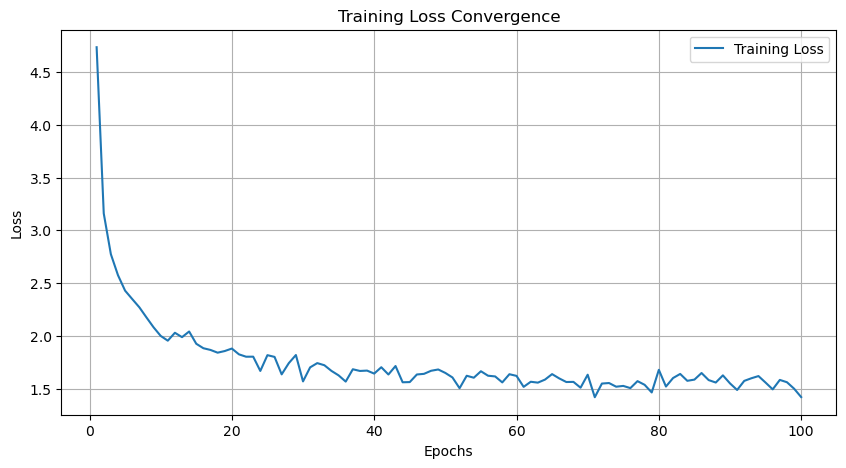

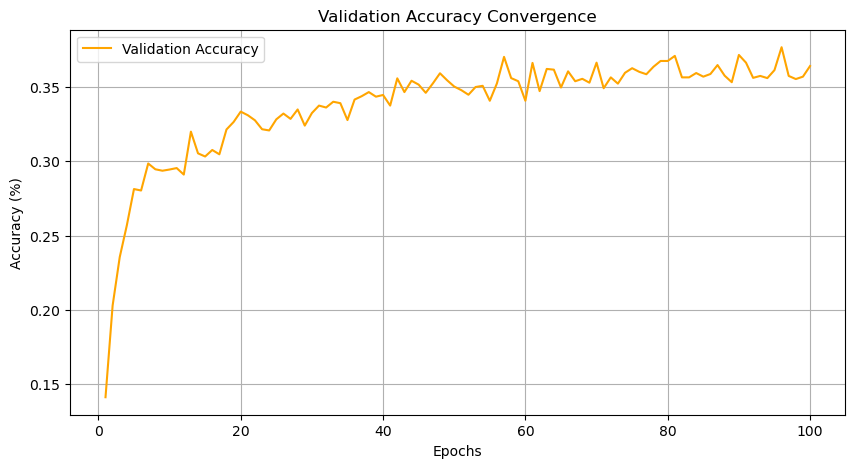

Accuracy of the network on the 6149 train images: 5.789559277931371 %


In [247]:
# Plotting the convergence curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Convergence')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Convergence')
plt.grid(True)
plt.legend()
plt.show()

net.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(total, 100 * correct / total))

In [250]:
# Load the trained model
model = Net(num_classes)
model.eval()

# Make a single inference on an image
image_path = 'azalea.jpg'
image = preprocess_image(image_path)
with torch.no_grad():
    outputs = model(image)

# Get the predicted class
_, predicted = torch.max(outputs, 1)
predicted_class = predicted.item()
print("Predicted class:", predicted_class)

Predicted class: 38
